In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams

from pandas import Series, DataFrame

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 8, 6
sb.set_style('whitegrid')

###### Basic Parameters

In [3]:
m_rate = 0.01                        # mortality rate (Note: that this is redefined later in the analysis to add randomness and make model the breakdown of healthcare systems for example a shortage of ICU beds)
inf_symp = 5.2                       # Days from infection to symptoms
symp_test = 3                        # Days from symptoms to testing
symp_death = 16.6                    # Days from symptoms to death
inf_death = inf_symp + symp_death    # Days from infection to death
inf_death

21.8

In [4]:
mu, sigma = 3, 1 # mean and standard deviation         

t_double = round(np.random.normal(mu, sigma))           # Days for total number of infected persons (cumulative) to double
t_double                                                # Note that this is redefined later in the analysis to incorporate assumptions about social distancing measures

3

Note that the actual values vary depending on the level of social distancing and other measures. In recent days prior to widespread social distancing the t_double rate has been around 2 - 3 days in the UK and US. In countries which have imposed restrictions this is extended to around 5 days with full lock down as seen in Wuhan significantly slowing the spread. However, as we will see there is a 3 week lag before the number of deaths starts to fall.

###### Basic Death Rate Model

Assumptions:
 - Deaths from coronavirus accurately rrefelct the number of deaths in a country
 - The people infected from by the disease on average were infected inf_death days ago (c. 20-22 days)
 - On this basis we can use the mortality rate to infer the true number of people infected at that time.
 - If we have one death on t0 then at a 1% mortality rate at t-20 100 people were infected.
 - The true number of people infected, and thus capable of spreading the infection differs from the number of reported cases as:
     - (1) reported cases lag the point of infected by around 8 - 12 days (depending on availability and speed of tests)
     - (2) many people have mild symptoms or may even be asymptomatic and so never get tested, or restrictions on the availability of tests mean that only those with severe symptoms get tested. There is significant variation across countries. South Korea had conducted 295,000 tests by March 17th with 2.85% returning positive. In contrast by March 14th the US had only tested 44,872 samples with 14.5% testing positive. Clearly, the reported case numbers are highly suspect and it is difficult to compare across countries. However, it seems fair to assume that the numbers of deaths due to COVID-19 are much more accurate.
 
 

The aim of this model is to estimate the number of true cases in a country based on the available data and thus project forward

##### <span style="color:red">Choose day on which to start analysis</span>

Examples:
United States: 
- T0 = March 9th
- T0_deaths = 26, however 19 of those are linked to a single healthcare facility in washington state in which mortality was around 25%. Treating this local outbreak as a cluster of six cases more accurately reflects the current data i.e. 12
- Social distancing started on c. March 16th (7 days after T0)
- Lock-down is yet to be announced, given the likely increase in deaths over the coming days let's assume 23rd March (14 days after T0)

United Kingdom: 
- T0 = March 10th
- T0_deaths = 10
- social_dist = 6 (March 16th)
- extreme_dist = 12 (TBD)

Italy: 
- T0 = Feb 25th
- T0_deaths = 11
- social_dist = 9 (March 4th)
- extreme_dist = 14 (March 9th)
- <i>(Note that death rate is higher in Italy than would be expected, a more accurate image can be found by adjusting the mortality rate slightly higher)<i>

In [5]:
country = 'IT'                # Used to name csv file which is linked to excel dashboard ['US', 'UK', 'IT']
T0 = 0                        # The day on which we start modelling
T0_deaths = 11                # The cumulative number of deaths at T0. It is helpful to choose a day on which the total deaths is greater than 10
social_dist = 9            # Day on which social distancing policies enacted
extreme_dist = 14          # Day on which almost inevitable lock-down enacted

In [6]:
Tstart = T0 - inf_death       # The day in which those people were infected (note that the model assume all 10 people were infected on Tstart)
Tstart = round(Tstart)

Tstart_infections = T0_deaths / m_rate
Tstart_infections

1100.0

###### Calculate the daily rate of infection required to achieve a specific doubling rate

doubling_time = ln(2) / ln (1 + r)

where r = daily rate of infection

Using the lact that ln(x) = y where e^y = x we can restate the equation as

r = e^(ln(2)/doubling_time) - 1

##### <span style="color:red">Set day when social distancing begins, adjust assumptions on the doubling time before and after, choose number of days to project forward</span>

In [7]:
Tx_infections = Tstart_infections

persons_infected = {}
Tx = Tstart

days_to_project = 60       # Choose how many days to project forward. Longer time horizons have greater uncertainty. The model does not make assumtpions about herd immunity etc.

for i in range(days_to_project + abs(Tx)):                      
    persons_infected.update({Tx : Tx_infections})       # For each day add the day and the number of people infected as a key, value pair to the dictionary 
    Tx = Tx + 1
    
    # Introduce randomness into rate of change and model increase in doubling time as measures are introduced
    if Tx < social_dist:                                # Business as usual
        mu, sigma = 3, 0.2  # mean, s.d
    elif Tx < extreme_dist:                             # Moderate social distancing
        mu, sigma = 10, 0.5                      
    else:                                               # Lock-down
        mu, sigma = 100, 10                  

    t_double = abs(np.random.normal(mu, sigma))         # Days for total number of infected persons (cumulative) to double
    r = np.exp( np.log(2) / t_double) - 1
    
    Tx_infections = round(Tx_infections*(1+r))          # Cumulative total number of infected persons on Tx

persons_infected

{-22: 1100.0,
 -21: 1409.0,
 -20: 1771.0,
 -19: 2223.0,
 -18: 2773.0,
 -17: 3477.0,
 -16: 4344.0,
 -15: 5697.0,
 -14: 7301.0,
 -13: 9265.0,
 -12: 11662.0,
 -11: 14451.0,
 -10: 18433.0,
 -9: 23812.0,
 -8: 30297.0,
 -7: 38823.0,
 -6: 50343.0,
 -5: 63485.0,
 -4: 79815.0,
 -3: 102569.0,
 -2: 128584.0,
 -1: 160161.0,
 0: 199940.0,
 1: 254297.0,
 2: 315790.0,
 3: 404895.0,
 4: 507170.0,
 5: 653956.0,
 6: 836906.0,
 7: 1045011.0,
 8: 1320426.0,
 9: 1429574.0,
 10: 1531439.0,
 11: 1638687.0,
 12: 1755078.0,
 13: 1878943.0,
 14: 1892874.0,
 15: 1905100.0,
 16: 1917552.0,
 17: 1933007.0,
 18: 1944685.0,
 19: 1958273.0,
 20: 1972301.0,
 21: 1985803.0,
 22: 1999306.0,
 23: 2013297.0,
 24: 2029518.0,
 25: 2043692.0,
 26: 2058004.0,
 27: 2073676.0,
 28: 2088886.0,
 29: 2102706.0,
 30: 2116573.0,
 31: 2131765.0,
 32: 2146134.0,
 33: 2160230.0,
 34: 2175858.0,
 35: 2190398.0,
 36: 2204692.0,
 37: 2220666.0,
 38: 2237446.0,
 39: 2252443.0,
 40: 2266742.0,
 41: 2283280.0,
 42: 2301795.0,
 43: 2319279.0,

In [8]:
df = pd.DataFrame(persons_infected.items())             # Create a dataframe from the results
df.columns = ['time','true_infections']

###### Projecting the future death rate

At T0 the death rate is T-22 * mortality rate. T1, it is T-21  * mortality rate and so on.


In [9]:
death_projection = {}
day_counter = T0
cumulative_deaths = 0


for i, j in persons_infected.items():                     
    
    mu, sigma = 0.015, 0.002         # mean, standard deviation
    m_rate = abs(np.random.normal(mu, sigma))     # set mortality rate
    
    death_data = []
    
    # Set the initial values for Tstart
    if i == Tstart:
        cumulative_infections = df.iloc[i - Tstart]['true_infections']       # Value taken directly from persons_infected df
        new_infections = 0
        
        new_deaths = 0
        cumulative_deaths = 0
        
        death_data = [cumulative_infections, new_infections, cumulative_deaths, new_deaths]
    
    # For days between Tstart and T0 calculate new infections but not deaths
    elif i < T0:
        x = i - Tstart - 1       # Value of the day before
        
        cumulative_infections = df.iloc[i - Tstart]['true_infections']
        new_infections = cumulative_infections - df.iloc[x]['true_infections']   # Today less yesterday
        
        new_deaths = 0
        cumulative_deaths = round(new_deaths + cumulative_deaths) 
        
        death_data = [cumulative_infections, new_infections, cumulative_deaths, new_deaths]
    
    # For T0 calculate deaths based on earlier infections(not cumulative = new in this special case)
    elif i == T0:
        x = i - Tstart- 1
        x2 = round(i - Tstart - inf_death)        # Day c. 3 weeks ago used to calculate deaths today
        x3 = round(i - Tstart - inf_death - 1)    # And the day before that
        
        cumulative_infections = df.iloc[i - Tstart]['true_infections']
        new_infections = cumulative_infections - df.iloc[x]['true_infections']
        
        new_deaths = round( (df.iloc[x2]['true_infections'] - 0) * m_rate)       # Special case on T0 as no 'previous days'
        cumulative_deaths = round(new_deaths + cumulative_deaths)                 
        
        death_data = [cumulative_infections, new_infections, cumulative_deaths, new_deaths]
    
    # For days after T0 calculate new deaths based on number of new infections at Tx - inf_death (days between infection and death)
    else:
        x = i - Tstart- 1
        x2 = int(i - Tstart - inf_death)
        x3 = int(i - Tstart - inf_death - 1)
        
        cumulative_infections = df.iloc[i - Tstart]['true_infections']
        new_infections = cumulative_infections - df.iloc[x]['true_infections']
        
        
        # If the number of deaths per day reaches 1000 then rasie the mortality rate from average 1.5% to 4% reflecting crisis
        if (df.iloc[x2]['true_infections'] - df.iloc[x3]['true_infections'])* m_rate > 1000:
            mu, sigma = 0.04, 0.002         # mean, standard deviation
            crisis_m_rate = abs(np.random.normal(mu, sigma))
            new_deaths = round( (df.iloc[x2]['true_infections'] - df.iloc[x3]['true_infections'] ) * crisis_m_rate)
        else:
            new_deaths = round( (df.iloc[x2]['true_infections'] - df.iloc[x3]['true_infections'] ) * m_rate)
                                
        cumulative_deaths = round(new_deaths + cumulative_deaths)
        
        death_data = [cumulative_infections, new_infections, cumulative_deaths, new_deaths]
        
    death_projection.update({day_counter : death_data})
    day_counter = day_counter + 1
    
death_projection

{0: [1100.0, 0, 0, 0],
 1: [1409.0, 309.0, 0, 0],
 2: [1771.0, 362.0, 0, 0],
 3: [2223.0, 452.0, 0, 0],
 4: [2773.0, 550.0, 0, 0],
 5: [3477.0, 704.0, 0, 0],
 6: [4344.0, 867.0, 0, 0],
 7: [5697.0, 1353.0, 0, 0],
 8: [7301.0, 1604.0, 0, 0],
 9: [9265.0, 1964.0, 0, 0],
 10: [11662.0, 2397.0, 0, 0],
 11: [14451.0, 2789.0, 0, 0],
 12: [18433.0, 3982.0, 0, 0],
 13: [23812.0, 5379.0, 0, 0],
 14: [30297.0, 6485.0, 0, 0],
 15: [38823.0, 8526.0, 0, 0],
 16: [50343.0, 11520.0, 0, 0],
 17: [63485.0, 13142.0, 0, 0],
 18: [79815.0, 16330.0, 0, 0],
 19: [102569.0, 22754.0, 0, 0],
 20: [128584.0, 26015.0, 0, 0],
 21: [160161.0, 31577.0, 0, 0],
 22: [199940.0, 39779.0, 16.0, 16.0],
 23: [254297.0, 54357.0, 21.0, 5.0],
 24: [315790.0, 61493.0, 27.0, 6.0],
 25: [404895.0, 89105.0, 33.0, 6.0],
 26: [507170.0, 102275.0, 40.0, 7.0],
 27: [653956.0, 146786.0, 51.0, 11.0],
 28: [836906.0, 182950.0, 65.0, 14.0],
 29: [1045011.0, 208105.0, 82.0, 17.0],
 30: [1320426.0, 275415.0, 100.0, 18.0],
 31: [1429574.0,

In [10]:
df_all = pd.DataFrame(death_projection.items())       
df_all.columns = ['time','data']
df_all = df_all.set_index('time')
df_all

,data
time,
0,"[1100.0, 0, 0, 0]"
1,"[1409.0, 309.0, 0, 0]"
2,"[1771.0, 362.0, 0, 0]"
3,"[2223.0, 452.0, 0, 0]"
4,"[2773.0, 550.0, 0, 0]"
...,...
77,"[2522512.0, 18469.0, 72084.0, 252.0]"
78,"[2542342.0, 19830.0, 72343.0, 259.0]"
79,"[2557827.0, 15485.0, 72505.0, 162.0]"


In [11]:
# split out list into four columns and drop the original column
df_all[['cumulative_infections', 'new_infections', 'cumulative_deaths', 'new_deaths']] = pd.DataFrame(df_all.data.values.tolist(), index = df_all.index)
df_all = df_all.drop(['data'], axis=1)

In [12]:
csv_name = country + '-virus.csv'
df_all.to_csv(csv_name)  

(0, 11996.25)

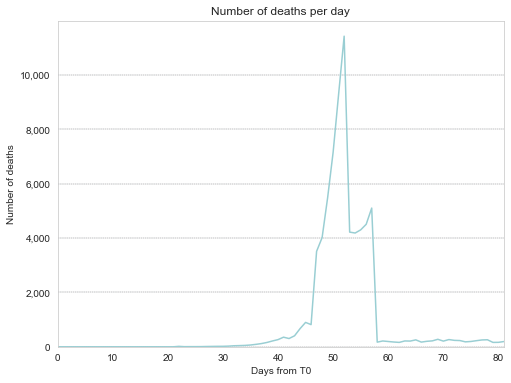

In [13]:
ax = df_all['new_deaths'].plot(color='#99CED3')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Days from T0')
plt.ylabel('Number of deaths')
plt.title('Number of deaths per day')
plt.grid(axis='y', linestyle='dashed', color='#5F6366', linewidth=0.4)
plt.grid(axis='x')
plt.ylim(bottom=0) 

(0, 76506.15)

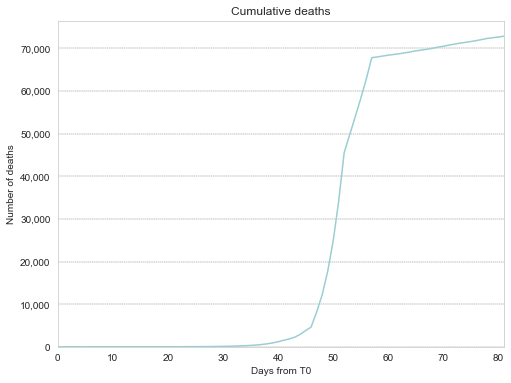

In [14]:
ax = df_all['cumulative_deaths'].plot(color='#99CED3')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Days from T0')
plt.ylabel('Number of deaths')
plt.title('Cumulative deaths')
plt.grid(axis='y', linestyle='dashed', color='#5F6366', linewidth=0.4)
plt.grid(axis='x')
plt.ylim(bottom=0) 

(0, 289185.75)

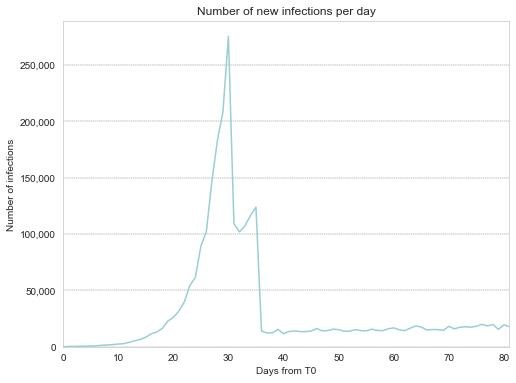

In [15]:
ax = df_all['new_infections'].plot(color='#99CED3')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Days from T0')
plt.ylabel('Number of infections')
plt.title('Number of new infections per day')
plt.grid(axis='y', linestyle='dashed', color='#5F6366', linewidth=0.4)
plt.grid(axis='x')
plt.ylim(bottom=0) 

(0, 2724798.95)

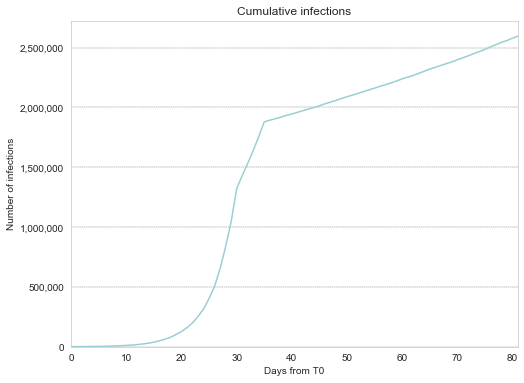

In [16]:
ax = df_all['cumulative_infections'].plot(color='#99CED3')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Days from T0')
plt.ylabel('Number of infections')
plt.title('Cumulative infections')
plt.grid(axis='y', linestyle='dashed', color='#5F6366', linewidth=0.4)
plt.grid(axis='x')
plt.ylim(bottom=0) 

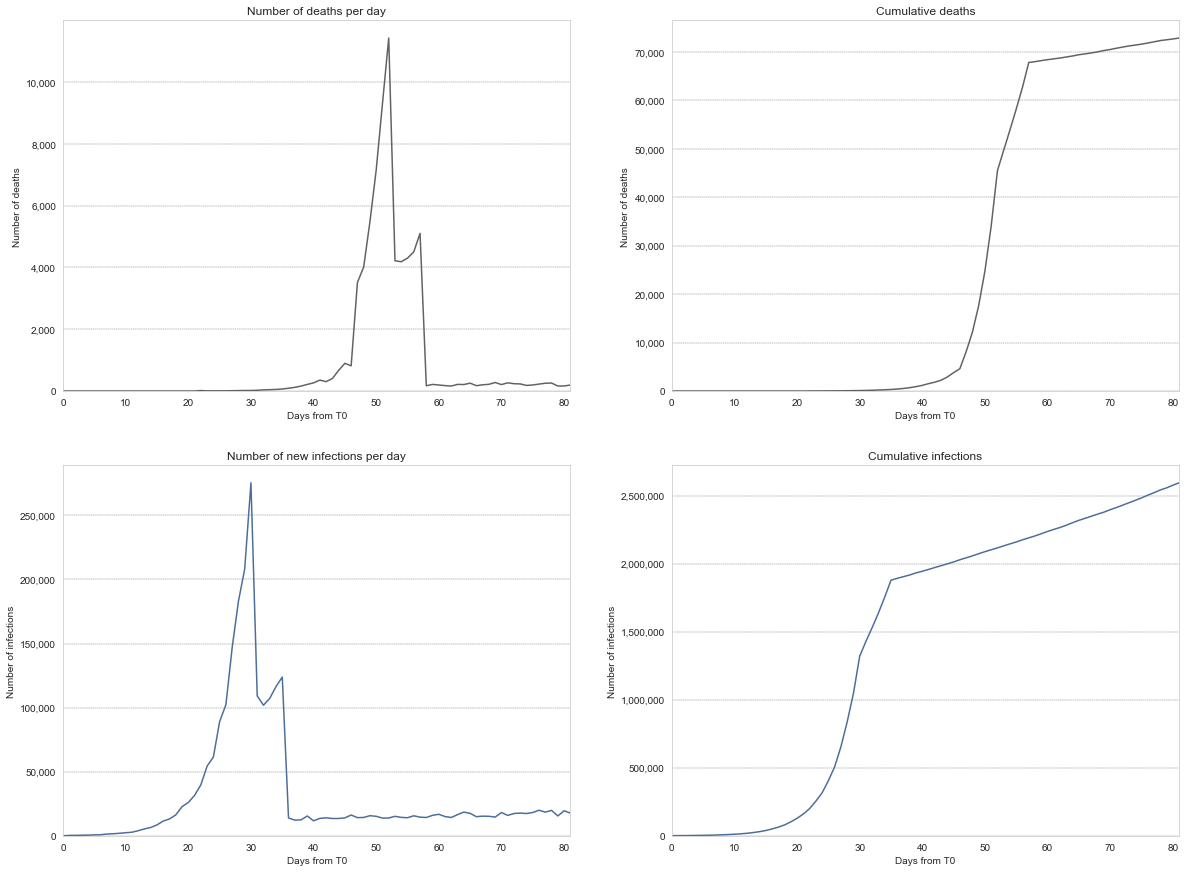

In [17]:
x = range(10)
y = range(10)

fig = plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
ax1 = df_all['new_deaths'].plot(color='#5F6366')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Days from T0')
plt.ylabel('Number of deaths')
plt.title('Number of deaths per day')
plt.grid(axis='y', linestyle='dashed', color='#5F6366', linewidth=0.4)
plt.grid(axis='x')
plt.ylim(bottom=0) 

plt.subplot(2, 2, 2)
ax2 = df_all['cumulative_deaths'].plot(color='#5F6366')
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Days from T0')
plt.ylabel('Number of deaths')
plt.title('Cumulative deaths')
plt.grid(axis='y', linestyle='dashed', color='#5F6366', linewidth=0.4)
plt.grid(axis='x')
plt.ylim(bottom=0) 

plt.subplot(2, 2, 3)
ax3 = df_all['new_infections'].plot(color='#4D6D9A')
ax3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Days from T0')
plt.ylabel('Number of infections')
plt.title('Number of new infections per day')
plt.grid(axis='y', linestyle='dashed', color='#5F6366', linewidth=0.4)
plt.grid(axis='x')
plt.ylim(bottom=0) 

plt.subplot(2, 2, 4)
ax4 = df_all['cumulative_infections'].plot(color='#4D6D9A')
ax4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Days from T0')
plt.ylabel('Number of infections')
plt.title('Cumulative infections')
plt.grid(axis='y', linestyle='dashed', color='#5F6366', linewidth=0.4)
plt.grid(axis='x')
plt.ylim(bottom=0)

plt.show()